In [11]:
from models import *
from data import DataMoudle
from main import HYPERPARAMS
from matplotlib import pyplot as plt

dataset = DataMoudle(**HYPERPARAMS['dataset'])
x, y = dataset.dataset[0]
print(dataset.positive_data.step_list)

x = x.unsqueeze(0)
murenn = MuReNN(**HYPERPARAMS['model'])
murenn(x)

conv1d = Conv1D(**HYPERPARAMS['model'])
conv1d(x)

wavenet = WaveNet(**HYPERPARAMS['model'])
wavenet(x)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

tensor([[0.5813]], grad_fn=<SigmoidBackward0>)

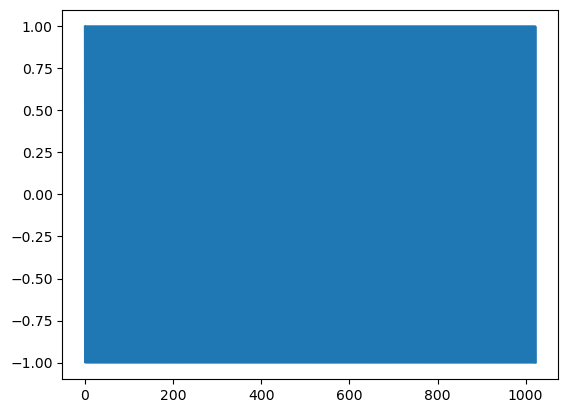

In [12]:
d = dataset.dataset
x, y = d[250]
plt.plot(x[0].numpy())

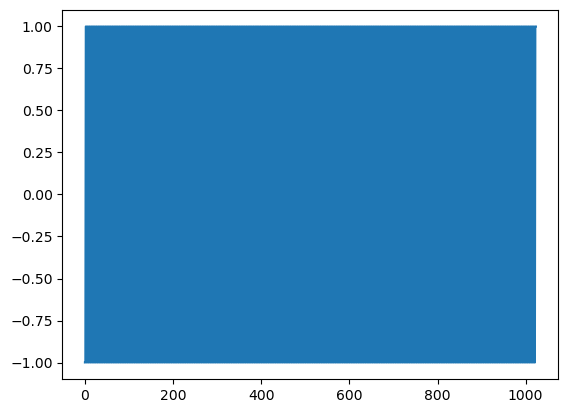

In [13]:
d = dataset.dataset
x, y = d[750]
plt.plot(x[0].numpy())

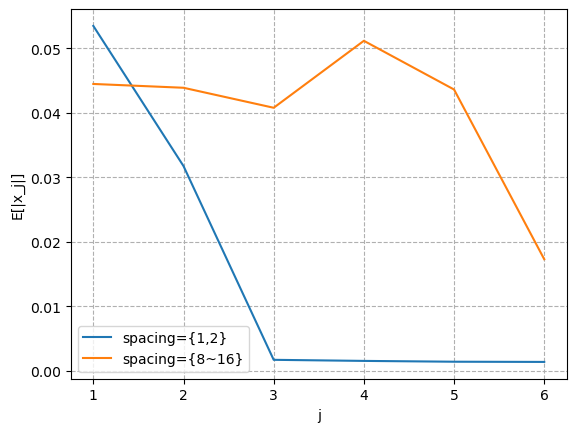

In [14]:
import murenn
import numpy as np
d = dataset.dataset
data = []
for x, y in d:
    data.append(x)
data = torch.stack(data,dim=0)
wt = murenn.DTCWT(J=6, alternate_gh=False, normalize=True)
_, hps = wt(data)

Ejs = []
for hp in hps:
    Ejs.append(torch.linalg.norm(hp, dim=-1).mean()/hp.shape[-1])

spec2 = {
        'num_samples': 1000,
        'batch_size': 25,
        'seg_length': 2**10,
        'step_min': 1,
        'step_max': 2,
    },
dataset2 = DataMoudle(step_min = 8, step_max = 16, num_samples=1000, batch_size=25, seg_length=2**10)
ds = dataset2.dataset
data2 = []
for x, y in ds:
    data2.append(x)
data2 = torch.stack(data2,dim=0)
wt = murenn.DTCWT(J=6, alternate_gh=False, normalize=True)
_, hps2 = wt(data2)

Ejs2 = []
for hp in hps2:
    Ejs2.append(torch.linalg.norm(hp, dim=-1).mean()/hp.shape[-1])

plt.plot(range(1,7), np.asarray(Ejs), label='spacing={1,2}')
plt.plot(range(1,7), np.asarray(Ejs2), label='spacing={8~16}')
# plt.semilogy(range(1,7),[1/(2**j) for j in range(6)], label='1/(1.414^j)')
plt.xlabel('j')
plt.ylabel('E[|x_j|]')
plt.grid(linestyle='--',which='both')
# plt.title(r"subset with spacing = {1,2}")
plt.legend()

Text(0.5, 1.0, 'the sine wave dataset')

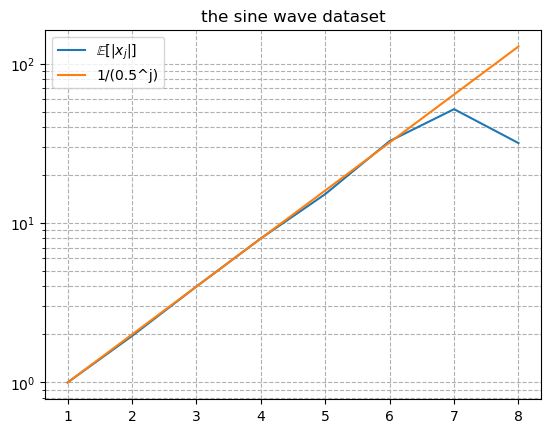

In [19]:
def generate_random_sine(sample_rate, f_min, f_max, length, batch_size):
    time = torch.arange(length).reshape(1, -1) / sample_rate
    log2_min = np.log2(f_min)
    log2_range = np.log2(f_max) - np.log2(f_min)
    while True:
        log2_f0 = log2_min + log2_range * torch.rand(batch_size)
        f0 = (2**log2_f0).reshape(-1, 1)
        yield torch.sin(2 * torch.pi * f0 * time)

sine_gen = generate_random_sine(16000, 64, 8000, 1024, 1000)
sine_data = next(sine_gen)
wt = murenn.DTCWT(J=8, alternate_gh=True, normalize=False)
_, hps = wt(sine_data.unsqueeze(0))
Ejs = []
for hp in hps:
    Ejs.append(((torch.linalg.norm(hp, dim=-1))).mean()/hp.shape[-1])
plt.semilogy(range(1,9), np.asarray(Ejs)/min(Ejs), label='$\mathbb{E}[|x_j|]$')
plt.semilogy(range(1,9),[1/(0.5**j) for j in range(8)], label='1/(0.5^j)')
plt.legend()
plt.grid(linestyle='--',which='both')
plt.title(r"the sine wave dataset")